In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import os
import cv2
random.seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the dataset form google drive

In [3]:
dataset_path = "/content/drive/MyDrive/animals"
animals = os.listdir(dataset_path)
print(animals)

['panda', 'cats', 'dogs']


Selecting 1000 images from each class for balanced dataset.

In [4]:
selected_images = {}
for animal in animals:
  animal_path = os.path.join(dataset_path, animal)
  images = os.listdir(animal_path)
  if len(images) >= 3000:
    selected_images[animal] = random.sample(images, 3000)
  else:
    print(f"Class {animal} has less than 3000 images. Selecting all {len(images)} images.")
    selected_images[animal] = images

Class panda has less than 3000 images. Selecting all 1000 images.
Class cats has less than 3000 images. Selecting all 1000 images.
Class dogs has less than 3000 images. Selecting all 1000 images.


Initiating image properties and train_data size.

In [5]:
image_size = 32
images_count = 100
k_values = list(range(2, 20))

Suffile all 3000 images and randomly selecting **100** images to train

In [6]:
train_imgs = []

for index, animal in enumerate(animals):
    label = index
    path = os.path.join(dataset_path, animal)
    images = os.listdir(path)
    random.shuffle(images)

    for img in images[:images_count]:
        img_path = os.path.join(path, img)
        img_bgr = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        img_gray = cv2.resize(img_gray, (image_size, image_size))
        train_imgs.append([img_gray, label])

np.random.shuffle(train_imgs)

Viewing the images with label to varify

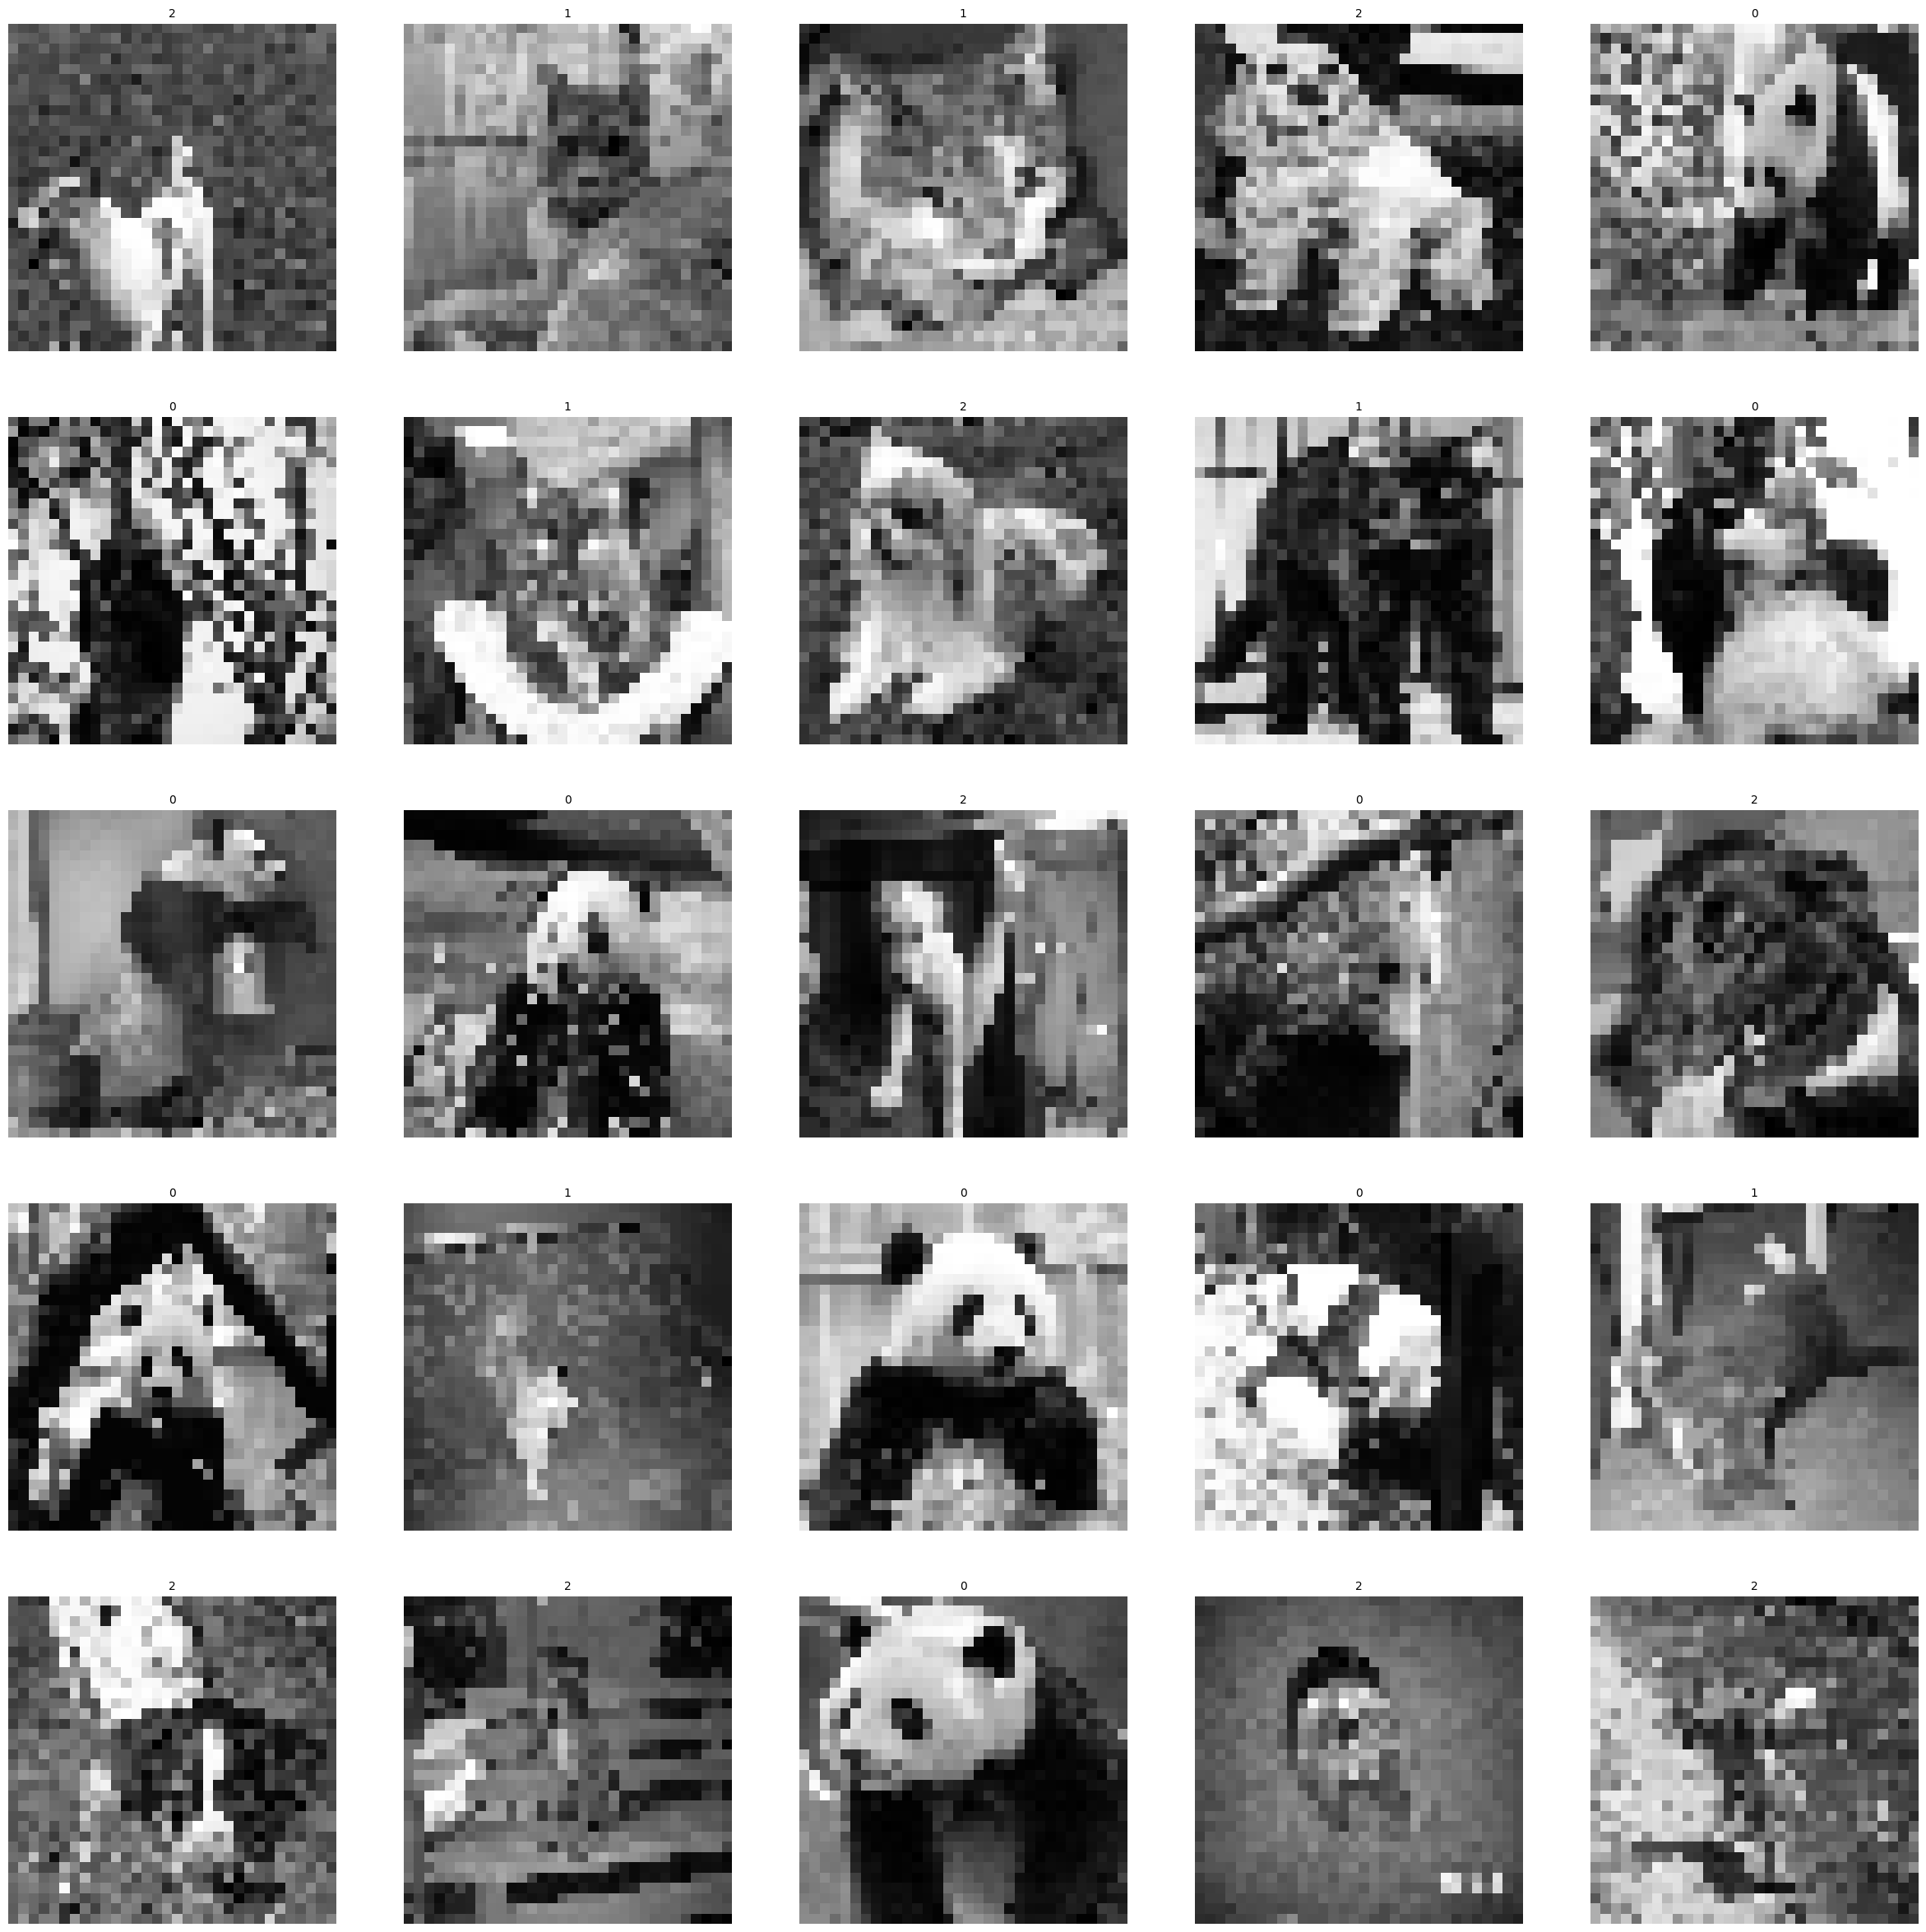

In [7]:
rows, cols = 5, 5
plt.figure(figsize=(30, 30))

for i in range(rows * cols):
    img, label = train_imgs[i]
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(label, fontsize=10)
    plt.axis('off')

plt.show()

Defining L1 and L2 distance functions

In [8]:
def l1_distance(a, b):
    return np.sum(np.abs(a - b))

def l2_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

In [9]:
def predict(X_train, y_train, x_test, k, dist_func):
    distances = [dist_func(x_test, x) for x in X_train]
    nearest = np.argsort(distances)[:k]
    nearest_labels = y_train[nearest]
    values, counts = np.unique(nearest_labels, return_counts=True)
    return values[np.argmax(counts)]

In [10]:
def cross_validation(X, Y, k_values, folds=5):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    fold_size = len(X) // folds
    fold_indices = [indices[i*fold_size:(i+1)*fold_size] for i in range(folds)]

    accuracy_l1 = {k: [] for k in k_values}
    accuracy_l2 = {k: [] for k in k_values}

    for i in range(folds):
        val_idx = fold_indices[i]
        train_idx = np.hstack([fold_indices[j] for j in range(folds) if j != i])
        X_train, Y_train = X[train_idx], Y[train_idx]
        X_val, Y_val = X[val_idx], Y[val_idx]

        for k in k_values:
            correct_l1 = correct_l2 = 0
            for x, y_true in zip(X_val, Y_val):
                pred_l1 = predict(X_train, Y_train, x, k, l1_distance)
                pred_l2 = predict(X_train, Y_train, x, k, l2_distance)
                correct_l1 += int(pred_l1 == y_true)
                correct_l2 += int(pred_l2 == y_true)
            accuracy_l1[k].append(correct_l1 / len(Y_val))
            accuracy_l2[k].append(correct_l2 / len(Y_val))
        print(f"Fold {i+1} completed.")

    avg_l1 = {k: np.mean(accuracy_l1[k]) for k in k_values}
    avg_l2 = {k: np.mean(accuracy_l2[k]) for k in k_values}
    return avg_l1, avg_l2

In [11]:
X = np.array([img[0].flatten() for img in train_imgs])
Y = np.array([img[1] for img in train_imgs])

avg_l1, avg_l2 = cross_validation(X, Y, k_values)

for k in k_values:
    print(f"Average Accuracy for k={k} (L1): {avg_l1[k]:.2f}")
    print(f"Average Accuracy for k={k} (L2): {avg_l2[k]:.2f}")

Fold 1 completed.
Fold 2 completed.
Fold 3 completed.
Fold 4 completed.
Fold 5 completed.
Average Accuracy for k=2 (L1): 0.37
Average Accuracy for k=2 (L2): 0.39
Average Accuracy for k=3 (L1): 0.40
Average Accuracy for k=3 (L2): 0.40
Average Accuracy for k=4 (L1): 0.39
Average Accuracy for k=4 (L2): 0.44
Average Accuracy for k=5 (L1): 0.38
Average Accuracy for k=5 (L2): 0.44
Average Accuracy for k=6 (L1): 0.40
Average Accuracy for k=6 (L2): 0.44
Average Accuracy for k=7 (L1): 0.39
Average Accuracy for k=7 (L2): 0.43
Average Accuracy for k=8 (L1): 0.38
Average Accuracy for k=8 (L2): 0.44
Average Accuracy for k=9 (L1): 0.37
Average Accuracy for k=9 (L2): 0.44
Average Accuracy for k=10 (L1): 0.40
Average Accuracy for k=10 (L2): 0.44
Average Accuracy for k=11 (L1): 0.38
Average Accuracy for k=11 (L2): 0.49
Average Accuracy for k=12 (L1): 0.38
Average Accuracy for k=12 (L2): 0.45
Average Accuracy for k=13 (L1): 0.39
Average Accuracy for k=13 (L2): 0.47
Average Accuracy for k=14 (L1): 0.36
A

Comparison between L1 and L2 distance

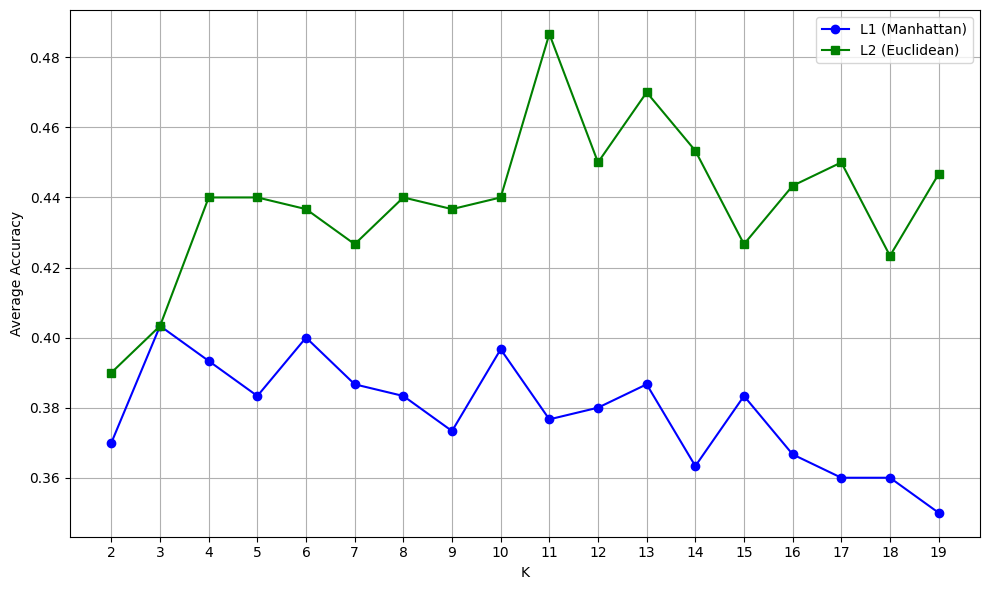

In [12]:
plt.figure(figsize=(10, 6))

plt.plot(k_values, [avg_l1[k] for k in k_values], marker='o', label='L1 (Manhattan)', color='blue')
plt.plot(k_values, [avg_l2[k] for k in k_values], marker='s', label='L2 (Euclidean)', color='green')

plt.xlabel("K")
plt.ylabel("Average Accuracy")
plt.xticks(k_values)  # Ensure integer ticks on x-axis
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The graph compares two distance methods in KNN:
L1 (Manhattan) in blue and L2 (Euclidean) in green.

It shows how accuracy changes as we try different values of K (2 to 19).

L2 (green) gives higher accuracy than L1 in almost all cases.

The best accuracy (about 49%) happens at K = 11 with L2.

Overall, L2 is better than L1 for this image classification task.

In [13]:
best_k_l1 = max(avg_l1, key=avg_l1.get)
best_k_l2 = max(avg_l2, key=avg_l2.get)

Showing the top 5 predictions

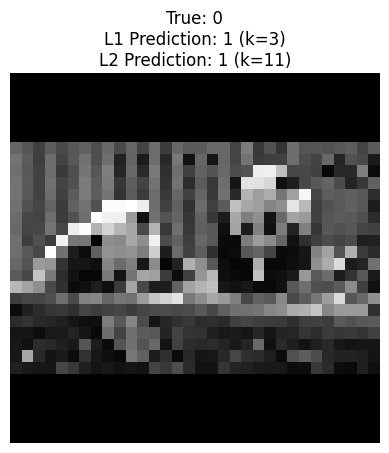

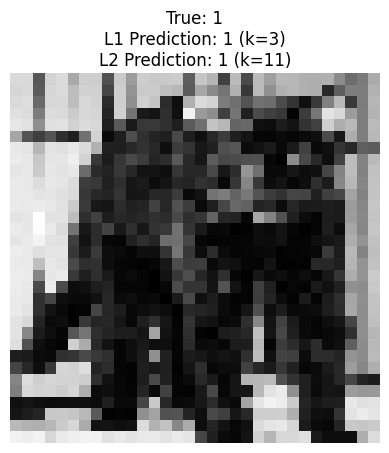

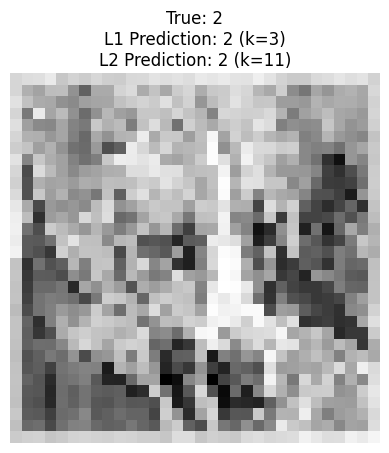

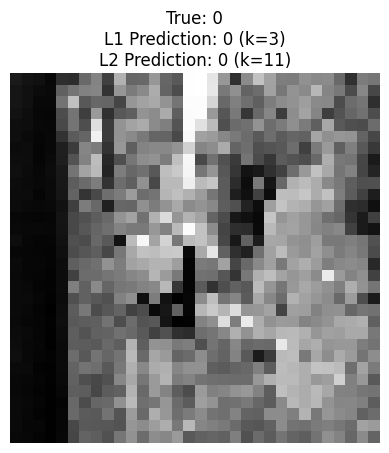

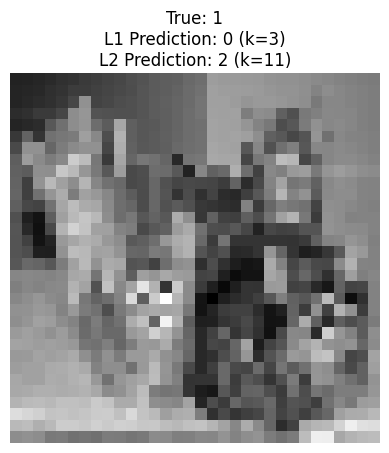

In [14]:
test_indices = random.sample(range(len(X)), 5)
X_test = X[test_indices]
Y_test = Y[test_indices]

for i, (x, true_label) in enumerate(zip(X_test, Y_test)):
    pred_l1 = predict(X, Y, x, k=best_k_l1, dist_func=l1_distance)
    pred_l2 = predict(X, Y, x, k=best_k_l2, dist_func=l2_distance)

    fig, ax = plt.subplots()
    ax.imshow(x.reshape(32, 32), cmap='gray')
    ax.axis('off')
    ax.set_title(
        f"True: {true_label}\n"
        f"L1 Prediction: {pred_l1} (k={best_k_l1})\n"
        f"L2 Prediction: {pred_l2} (k={best_k_l2})"
    )
    plt.show()

We see that L2 (K=11) performs better than L1 (K=3) because, with more options (K=11), L2 is likely able to consider more possibilities, which helps it make better predictions. Even though both models are classifying the same images, L2 makes fewer mistakes and seems to have a more refined understanding of the categories (like distinguishing between cats, dogs, and pandas).

Meanwhile, L1 (K=3) only looks at 3 options, which could make it more prone to mistakes, especially in cases where there’s some overlap between the categories or the image is ambiguous.

So, in this small sample, L2's higher K value (11) likely gives it more flexibility, making it more accurate. This matches what we saw in the graph, where L2 outperforms L1. We could interpret that L2 is more robust and better suited for our task because it's considering more features or possibilities, leading to more correct predictions overall.